In [1]:
import tensorflow as tf
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import skimage.transform as tform

couldn't import doomish
Couldn't import doom


In [2]:
p = PLE(FlappyBird(), fps=30, display_screen=False, force_fps=False)

In [3]:
p.init()

In [15]:
%%time

p.reset_game()

games = 1
total_rewards = []

while games < 10:
    action = np.random.choice([0,119], p=[.9,.1])
    reward = p.act(action)
    
    total_rewards.append(reward)
    
    if p.game_over():
        p.reset_game()
        games += 1

CPU times: user 5.69 s, sys: 192 ms, total: 5.88 s
Wall time: 16.7 s


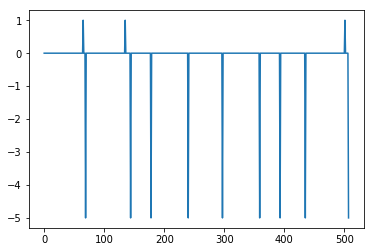

In [16]:
plt.plot(total_rewards)
plt.show()

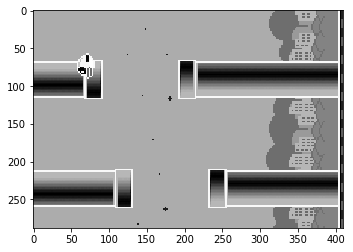

In [9]:
pic = p.getScreenRGB()
plt.imshow(pic[:,:410,1], cmap='Greys')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


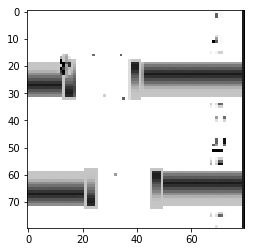

In [10]:
p.reset_game()
pic = p.getScreenRGB()
pic = pic[:,:410,0]
pic = tform.resize(pic, (80,80))
plt.imshow(pic, cmap='Greys')
plt.show()

# policy gradient learner

In [17]:
%%time

'''
gamma = 0.99

def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r
'''

def prepro(img):
    img = img[:,:410,1]
    # TODO: velocity transform here. Could be building difference frames or frame stacking.
    img = tform.resize(img, (80,80))
    return np.reshape(img, [1,80,80,1])
    
class agent():
    def __init__(self, lr, s_size, a_size):
        self.state_in= tf.placeholder(shape=[None, s_size, s_size, 1],dtype=tf.float32)
        
        w1 = tf.Variable(tf.random_normal([8,8,1,32], stddev=1), name='w1')
        w2 = tf.Variable(tf.random_normal([4,4,32,64], stddev=1), name='w2')
        w3 = tf.Variable(tf.random_normal([3,3,64,64], stddev=1), name='w3')
        w4 = tf.Variable(tf.random_normal([6400, 512], stddev=1), name='w4')
        w5 = tf.Variable(tf.random_normal([512, a_size], stddev=1), name='w5')
        
        conv1 = tf.nn.relu(tf.nn.conv2d(self.state_in, filter=w1, strides=[1,4,4,1], padding='SAME'))
        conv2 = tf.nn.relu(tf.nn.conv2d(conv1, filter=w2, strides=[1,2,2,1], padding='SAME'))
        conv3 = tf.nn.relu(tf.nn.conv2d(conv2, filter=w3, strides=[1,1,1,1], padding='SAME'))
        flat = tf.reshape(conv3, [-1, 6400])
        dense1 = tf.nn.relu(tf.matmul(flat, w4))
        self.output = tf.nn.softmax(tf.matmul(dense1, w5))
        
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
        
tf.reset_default_graph()

myAgent = agent(lr=0.01, s_size=80, a_size=2)

total_episodes = 1000
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        p.reset_game()
        s = prepro(p.getScreenRGB())
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:s})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)
            
            r = p.act(a)
            s1 = prepro(p.getScreenRGB())
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if p.game_over() == True:
                ep_history = np.array(ep_history)
                #ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        if i % 100 == 0:
            print(np.mean(total_reward[-100:]))
        i += 1

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


-5.0
-5.0
-5.0
-5.0
-5.0
-5.0
-5.0
-5.0
-5.0
-5.0
CPU times: user 7min 31s, sys: 13min 49s, total: 21min 21s
Wall time: 7min 53s


In [21]:
np.unique(np.asarray(total_reward))

array([-5.])